In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

import cvxpy as cp

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

import progressbar

In [23]:
plt.gcf().set_facecolor("white")
plt.rcParams.update({'font.size': 14})

<Figure size 432x288 with 0 Axes>

## Convex Program Solver using CVXPY library

In [24]:
def generate_Dmat(X, num_samples, input_dim, Dmat_max_itr):
    Dmat = np.empty((num_samples, 0))
    
    ## Finite approximation of all possible sign patterns
    for i in range(Dmat_max_itr):
        u = np.random.randn(input_dim, 1)
        Dmat = np.append(Dmat, (np.dot(X, u) >= 0) * 1.0, axis=1)
        Dmat = np.unique(Dmat, axis=1)
    
    print("Dmat Unique Shape:", Dmat.shape)
    
    return Dmat

In [25]:
def optimize_using_cvxpy(X, y_gt, num_samples, input_dim, Dmat_max_itr, beta=1e-4):
    Dmat = generate_Dmat(X, num_samples, input_dim, Dmat_max_itr)
    P = Dmat.shape[1]

    v = cp.Variable((input_dim, P))
    w = cp.Variable((input_dim, P))
    
    ## Below we use squared loss as a performance metric for binary classification
    y_pred = cp.Parameter((num_samples, 1))
    y_pred = cp.sum(cp.multiply(Dmat, X @ (v - w)), axis=1)

    loss_val = 0.5 * cp.sum_squares(y_pred - y_gt) + beta * (cp.mixed_norm(v.T, p=2, q=1) + cp.mixed_norm(w.T, p=2, q=1))

    constraints = []
    constraints += [cp.multiply((2*Dmat - np.ones((num_samples, P))), (X @ v)) >=0]
    constraints += [cp.multiply((2*Dmat - np.ones((num_samples, P))), (X @ w)) >=0]

    optimizer = cp.Problem(cp.Minimize(loss_val), constraints)
    optimizer.solve()
    opt_val = optimizer.value

    print("Convex program objective value (eq (8)): ", opt_val)
    
    return opt_val

## Using SGD to train a 2-layer ReLU neural network. 

In [26]:
class FCNetwork(nn.Module):
    def __init__(self, input_dim, num_hidden_units, num_classes):
        self.num_classes = num_classes
        super(FCNetwork, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Linear(input_dim, num_hidden_units, bias=True), nn.ReLU())
        self.layer2 = nn.Linear(num_hidden_units, num_classes-1, bias=True)
    
    def forward(self, x):
        num_samples = x.shape[0]
        x = x.reshape(num_samples, -1)

        output = self.layer2(self.layer1(x))
        return output

In [27]:
def compute_loss(h_theta_x, y_gt, model, beta=1e-4):
    loss = 0.5 * torch.linalg.norm(h_theta_x - y_gt, 2)**2
    
    for layer, theta in enumerate(model.parameters()):
        if layer == 0:
            loss += 0.5 * beta * torch.linalg.norm(theta, 'fro')**2
        elif layer == 1:
            if len(theta.shape) == 1:
                loss += 0.5 * beta * torch.linalg.norm(theta, 2)**2
            elif len(theta.shape) == 2:
                loss += 0.5 * beta * sum([torch.linalg.norm(theta[:, j], 1)**2 for j in range(theta.shape[1])])
    
    return loss

In [28]:
def generate_data_binary_classification(num_samples, input_dim, num_classes=2):
    assert(num_classes == 2)

    # generate data randomly from a uniform/standard normal N(0,1) dist
    X = np.random.randn(num_samples, input_dim)
    
    # Rule 1: generate binary labels. If x lies outside unit norm ball, then assign +1, else assign -1
    Y = ((np.linalg.norm(X[:, 0:input_dim], axis=1) > 1) - 0.5) * 2
    
    # Rule 2: generate binary labels for input dim=1. If x >= 0, assign +1, else assign -1
    # Y = ((X[:, 0:input_dim] >= 0) - 0.5) * 2
    
    # Rule 3: Y = np.random.choice([-1,1], (num_samples,))
    
    # Y = np.reshape(Y, (num_samples, 1))

    return X, Y

In [29]:
def generate_data_sklearn(num_samples, input_dim, num_classes):
    (X, Y) = make_blobs(n_samples=num_samples, n_features=input_dim, centers=num_classes, 
                        cluster_std=2.5, random_state=95)
        
    return X, Y

In [30]:
def get_next_batch(X, Y, batch_size):
    num_samples = X.shape[0]
    
    # loop over the dataset
    for i in range(0, num_samples, batch_size):
        # yield a tuple of the current batched data and labels
        yield(X[i:i + batch_size], Y[i:i + batch_size])

In [31]:
def sgd_solver(X_train, Y_train, X_test, Y_test, input_dim, num_hidden_units, num_classes, num_epochs, batch_size, 
               step_size=1e-3, beta=1e-4, schedule=0):
    
    num_train_samples = X_train.shape[0]
    num_test_samples = X_test.shape[0]
    
#     print("[INFO] Input dim: {}, Num hidden units: {}, Num classes: {}".format(input_dim, num_hidden_units, num_classes))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print("[INFO] Training using {}...".format(device))
    
    layer2_relu_model = FCNetwork(input_dim, num_hidden_units, num_classes).to(device)
#     print("[INFO] 2-layer ReLU Model:", layer2_relu_model)
    
#     solver_type = 'sgd'
    solver_type = 'adam'
    if solver_type == 'sgd':
        optimizer = torch.optim.SGD(layer2_relu_model.parameters(), lr=step_size, momentum=0.9)
    elif solver_type == 'adam':
        optimizer = torch.optim.Adam(layer2_relu_model.parameters(), lr=step_size)
    
    # lists for storing loss and accuracy
    train_loss_lst = []
    train_acc_lst = []
    test_loss_lst = []
    test_acc_lst = []
    
    if num_test_samples > 0:
        x_test_batch = Variable(X_test).to(device)
        y_test_batch = Variable(Y_test).to(device)
    
        h_theta_x = torch.reshape(layer2_relu_model(x_test_batch), (num_test_samples,))
        y_pred = torch.add((h_theta_x >= 0), -0.5) * 2

        loss_val = compute_loss(h_theta_x, y_test_batch, layer2_relu_model, beta)
        frac_corr_pred = torch.eq(y_pred, y_test_batch).float().sum() / num_test_samples

        test_loss_lst.append(loss_val.item())
        test_acc_lst.append(frac_corr_pred)
    
    if schedule == 1:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, factor=0.5, eps=1e-12)
    elif schedule == 2:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
    
    itr = 0
    for epoch in range(num_epochs):
        for (x_batch, y_batch) in get_next_batch(X_train, Y_train, batch_size):
            x_batch = Variable(x_batch).to(device)
            y_batch = Variable(y_batch).to(device)
            
            h_theta_x = torch.reshape(layer2_relu_model(x_batch), (batch_size,))
            y_pred = torch.add((h_theta_x >= 0), -0.5) * 2
            
            loss_val = compute_loss(h_theta_x, y_batch, layer2_relu_model, beta)
            frac_corr_pred = torch.eq(y_pred, y_batch).float().sum() / batch_size
    
            optimizer.zero_grad()   # make the gradients=0 before each backprop
            loss_val.backward()
            optimizer.step()
            
            train_loss_lst.append(loss_val.item())
            train_acc_lst.append(frac_corr_pred)
            
            itr += 1
        
        # compute test loss and accuracy every epoch
        if num_test_samples > 0:
            h_theta_x = torch.reshape(layer2_relu_model(x_test_batch), (num_test_samples,))
            y_pred = torch.add((h_theta_x >= 0), -0.5) * 2

            loss_val = compute_loss(h_theta_x, y_test_batch, layer2_relu_model, beta)
            frac_corr_pred = torch.eq(y_pred, y_test_batch).float().sum() / num_test_samples

            test_loss_lst.append(loss_val.item())
            test_acc_lst.append(frac_corr_pred)
        
#         if epoch % 1000 == 0:
#             print("[INFO] Epoch {}/{} - Train loss: {:0.3f}, Train acc: {:0.3f}, Test loss: {:0.3f}, Test acc: {:0.3f}".format(
#                 epoch, num_epochs, train_loss_lst[itr-1], train_acc_lst[itr-1], test_loss_lst[epoch+1], test_acc_lst[epoch+1] ))
    
#         if schedule > 0:
#             scheduler.step(train_loss_lst[itr-1])

    return train_loss_lst, train_acc_lst, test_loss_lst, test_acc_lst

In [32]:
def solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                        num_epochs, batch_size, split_data, num_trials, is_q8=False):
    
    # generate a 2-class classification problem with some data points
    # where each data point is a n-dim feature vector

#     print("[INFO] Generating data...")
    # X, Y = generate_data_sklearn(num_samples, input_dim, num_classes)
    X, Y = generate_data_binary_classification(num_samples, input_dim, num_classes)

    if split_data == True:
        # create training and testing splits
        (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.5, random_state=95)
    else:
        X_train = np.copy(X)
        Y_train = np.copy(Y)
        X_test = np.empty(0)
        Y_test = np.empty(0)

    num_train_samples = X_train.shape[0]
    num_test_samples = X_test.shape[0]

    # convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    Y_train_tensor = torch.from_numpy(Y_train).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    Y_test_tensor = torch.from_numpy(Y_test).float()
#     print("Generated tensor size:", X_train_tensor.shape, Y_train_tensor.shape, X_test_tensor.shape, 
#           Y_test_tensor.shape)

    fig = plt.figure(figsize=(16,14))
    ax1 = fig.add_subplot(2,2,1)
    ax1.set_yscale('log')
    ax1.title.set_text("Train Obj vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Value")
    plt.grid(linestyle='--')

    ax2 = fig.add_subplot(2,2,2)
    ax2.title.set_text("Train Acc vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Train Accuracy")
    plt.grid(linestyle='--')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.set_yscale('log')
    ax3.title.set_text("Test Obj vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Value")
    plt.grid(linestyle='--')
    
    ax4 = fig.add_subplot(2,2,4)
    ax4.title.set_text("Test Acc vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Test Accuracy")
    plt.grid(linestyle='--')
    
    plt.suptitle("Plot for m = "+str(num_hidden_units)+", n= "+str(num_train_samples)+", d = "+str(input_dim))

    lw = 2
#     color_lst = ['red', 'blue', 'brown', 'yellow', 'green', 'lightblue', 'darkred']

    for trial in range(num_trials):
        train_loss_lst, train_acc_lst, test_loss_lst, test_acc_lst = sgd_solver(X_train_tensor, Y_train_tensor, 
                                                                                X_test_tensor, Y_test_tensor, 
                                                                                input_dim, num_hidden_units, 
                                                                                num_classes, num_epochs, batch_size)

        line, = ax1.plot(train_loss_lst, linewidth=lw, label='Trial #'+str(trial+1))
        line, = ax2.plot(train_acc_lst, linewidth=lw, label='Trial #'+str(trial+1))
        line, = ax3.plot(test_loss_lst, linewidth=lw, label='Trial #'+str(trial+1))
        line, = ax4.plot(test_acc_lst, linewidth=lw, label='Trial #'+str(trial+1))

    # generate results using convex programming CVXPY
    X_train_new = np.append(X_train, np.ones((num_train_samples, 1)), axis=1)
    cvx_opt_val = optimize_using_cvxpy(X_train_new, Y_train, num_train_samples, input_dim+1, Dmat_max_itr=10000, 
                                       beta=1e-4)

    ax1.axhline(cvx_opt_val, color='black', linewidth=lw, linestyle='-', label='CVX-opt')
    
    if is_q8 == True:
        cvx_opt_val_approx = optimize_using_cvxpy(X_train_new, Y_train, num_train_samples, input_dim+1, 
                                                  Dmat_max_itr=100, beta=1e-4)

        ax1.axhline(cvx_opt_val_approx, color='darkred', linewidth=lw, linestyle='-', label='CVX-opt-approx')

    ax1.legend(prop={'size': 10})
    ax2.legend(prop={'size': 10})
    ax3.legend(prop={'size': 10})
    ax4.legend(prop={'size': 10})

    plt.show()

### Q7. Implement the first experiment from Fig 2 in [1]. Generate the data randomly. In particular for a small n (the sample size) and m = 5 (small number of hidden neurons), use the Stochastic Gradient Descent method to solve the non-convex problem m with different initializations. Plot the training objective value vs the number of iterations. Next, solve the convex program with CVX/CVXPY and plot its optimal value. What do you observe? Does the SGD always converge to the optimal value of the convex program? Perform the same experiment with larger values of m. Do your observations agree with the theoretical guarantees?

- We generated random IID data of dimension 1 sampled from standard normal distribution $\mathcal{N}(0,1)$. We used training sample size $n = 20$ and test sample size $n = 20$ (small n) - both data subsets sampled from the same distribution, and number of hidden neurons $m = 5, 15, 50, 100$.


- SGD does not always converge to the optimal value obtained by the convex optimizer (CVXPY library) as the training loss curve of SGD is always above the optimal value. This might be due to SGD being stuck at local optimal solutions as the SGD is applied over a non-convex loss function. From these experiments, for small m, SGD is unable to minimize training loss beyond a certain point. In some cases, it might seem that SGD loss curve is going below the convex optimal value. This is due to the fact that in the convex optimization, we are using an approximate value of P due to high computational cost. Increasing the number of random samples of $u$ vectors to $1e^8$ might end up in getting exact P value. 


- Yes, our observations agree with the theoretical guarantees in paper [1]. As we increase the number of hidden neurons $m$ from 5, 15, 50 upto 100, we observe that more and more SGD trials with random initializations are converging approximately very close to the optimal value obtained by the convex optimizer (CVXPY solver). This shows that as we increase $m$, the learning capacity of the 2-layer ReLU network improves and therefore, the training loss reaches closer to the global optimal value. For small m (let's say m=5, 15), and n = 20, $1 \leq m^* \leq n$, therefore, the condition for strong duality in Theorem 1 $m \geq m^*$ might not hold. But with large m (say m=50, 100), the strong duality condition is definitely fulfilled, and hence we see most of the random trials converging very close to the convex optimal loss value. 

Dmat Unique Shape: (20, 40)
Convex program objective value (eq (8)):  0.0020884593772920092


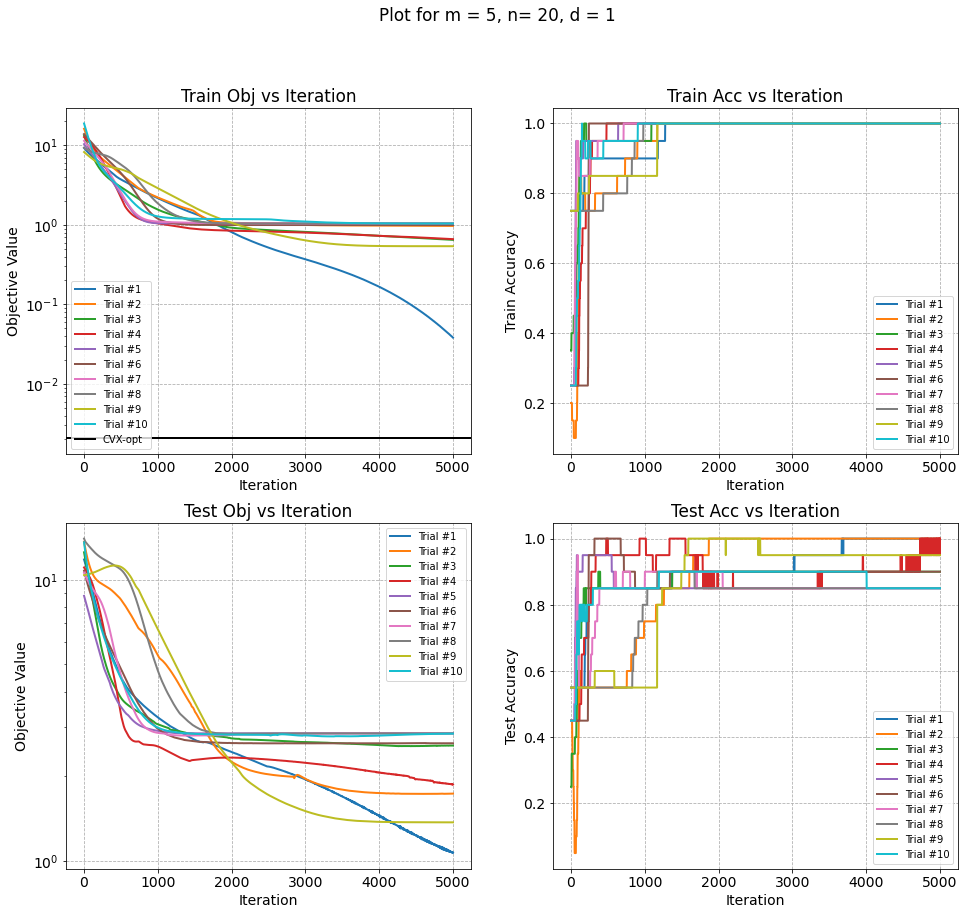

In [33]:
input_dim = 1
num_hidden_units = 5
num_classes = 2
num_samples = 40
num_epochs = 5000
batch_size = 20
split_data = True
num_trials = 10

solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                    num_epochs, batch_size, split_data, num_trials)

Dmat Unique Shape: (20, 40)
Convex program objective value (eq (8)):  0.004005579677215383


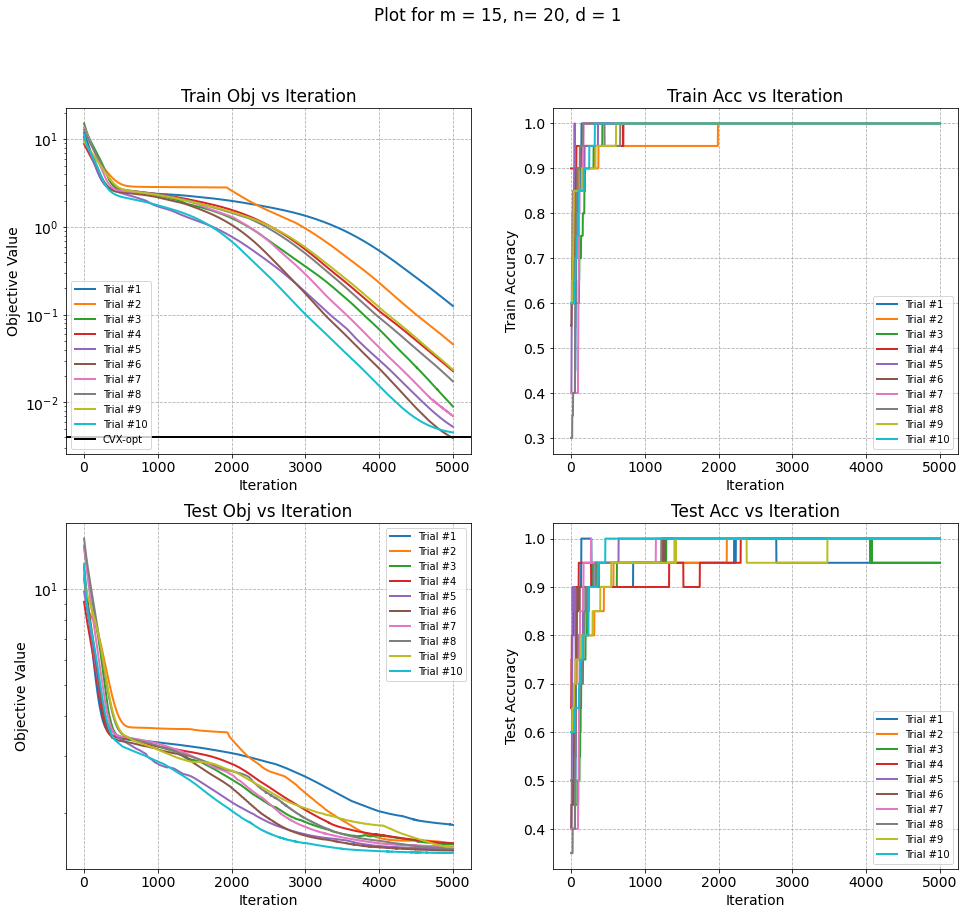

In [34]:
input_dim = 1
num_hidden_units = 15
num_classes = 2
num_samples = 40
num_epochs = 5000
batch_size = 20
split_data = True
num_trials = 10

solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                    num_epochs, batch_size, split_data, num_trials)

Dmat Unique Shape: (20, 40)
Convex program objective value (eq (8)):  0.003980895820738493


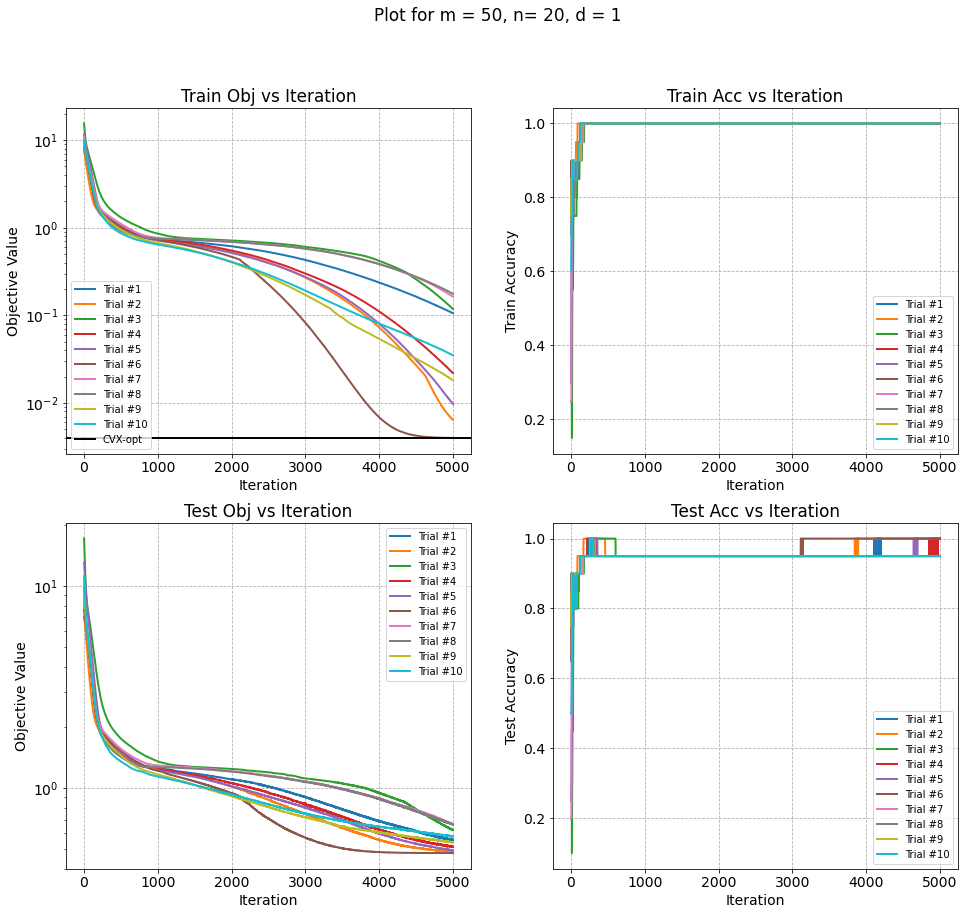

In [35]:
input_dim = 1
num_hidden_units = 50
num_classes = 2
num_samples = 40
num_epochs = 5000
batch_size = 20
split_data = True
num_trials = 10

solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                    num_epochs, batch_size, split_data, num_trials)

Dmat Unique Shape: (20, 40)
Convex program objective value (eq (8)):  0.003515337432210059


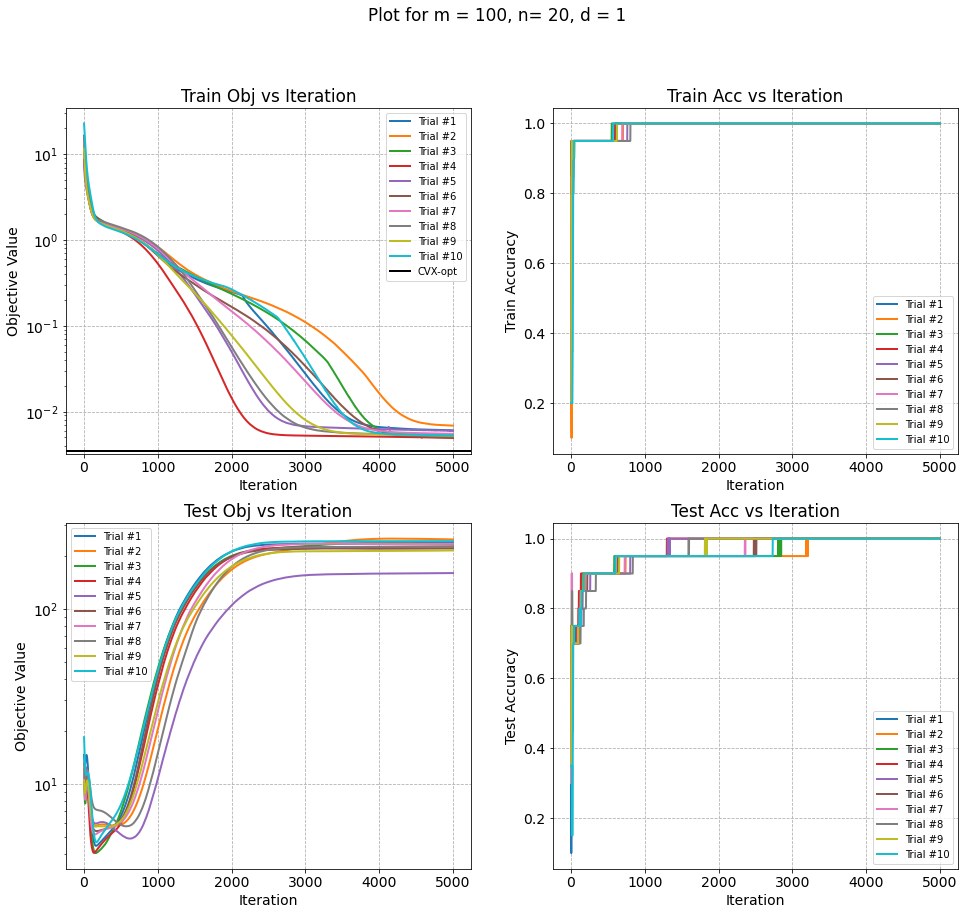

In [36]:
input_dim = 1
num_hidden_units = 100
num_classes = 2
num_samples = 40
num_epochs = 5000
batch_size = 20
split_data = True
num_trials = 10

solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                    num_epochs, batch_size, split_data, num_trials)

### Q8. Replicate this experiment for a larger value of n and an appropriate m. Plot the objective value against the number of iterations. How does this experiment differ from the case for small n? In addition to the original convex program, solve the approximate convex program described in Remark 3.3. Compare the objective value of the approximate version with both SGD and convex program. What is the advantage of solving the approximate convex program?

- For this experiment, we increased our training data sample size ($n$) from 20 to 500 and varied $m$ to be 5, 10, 50, 100. 


- The convex problem can be approximated by sampling a set of diagonal matrices from P unique diagonal matrices. According to the authors, this approximation to solve convex problem works extremely well and often better than backpropagation. This method has advantage over the original problem as it can be solved faster and sometimes it is the only way to solve convex problem when data or network size is large.


- We observe that for small number of hidden neurons $n$, the SGD loss curve is above both the exact convex and approximate convex optimal values. But for larger $m$, the SGD loss curve crosses and goes below the approximate convex optimal value (in some cases) but still stays above the exact convex optimal value. This is reasonable as increasing $m$ increases the learning and representation capacity of the NN. In any case, approximate convex optimal value is still better than SGD with small $m$ values.


- **Advantage of solving the approximate convex program:** The convex problem requires computing P diagonal matrices $D_i$ corresponding to the total number of partitions P. For each diagonal matrix $D_i$, we sample $u \in R^d$ and compute $1[Xu \geq 0]$ which corresponds to the diagonal entries of $D_i$. Many of these diagonal matrices are repeated while we sample random $u$ vector. In order to estimate diagonal matrices corresponding to all P partitions, we need to sample $u$ large number of times (~$10^6$). In addition, large number of these diagonal matrices also requires large amount of time for the CVXPY library to reach optimal solution. Therefore, solving approximate convex program requires us to estimate only a small subset of these partitions making the convex optimization solver much faster compared to solving the convex exact version. 

Dmat Unique Shape: (500, 869)


/Users/siriusA/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Convex program objective value (eq (8)):  0.2123580629922117
Dmat Unique Shape: (500, 73)
Convex program objective value (eq (8)):  0.8429447811590626


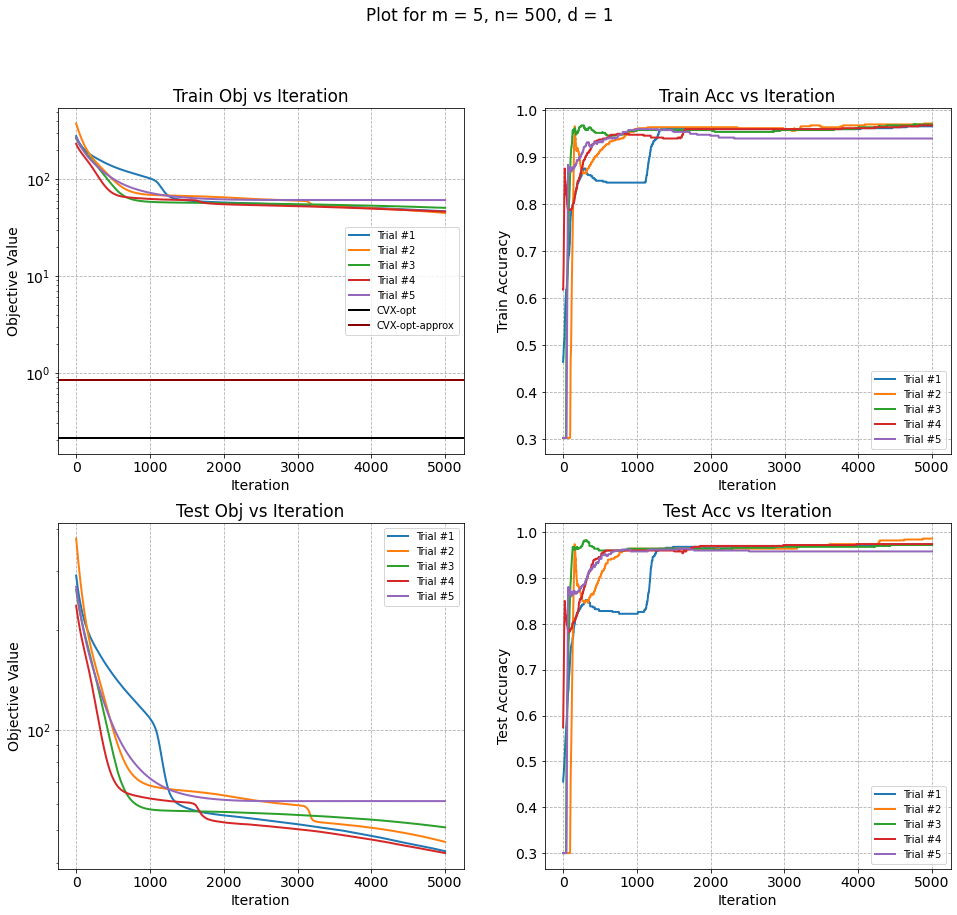

In [37]:
input_dim = 1
num_hidden_units = 5
num_classes = 2
num_samples = 1000
num_epochs = 5000
batch_size = 500
split_data = True
num_trials = 5

solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                    num_epochs, batch_size, split_data, num_trials, is_q8=True)

Dmat Unique Shape: (500, 877)
Convex program objective value (eq (8)):  0.21376574802201603
Dmat Unique Shape: (500, 75)
Convex program objective value (eq (8)):  4.851033055198961


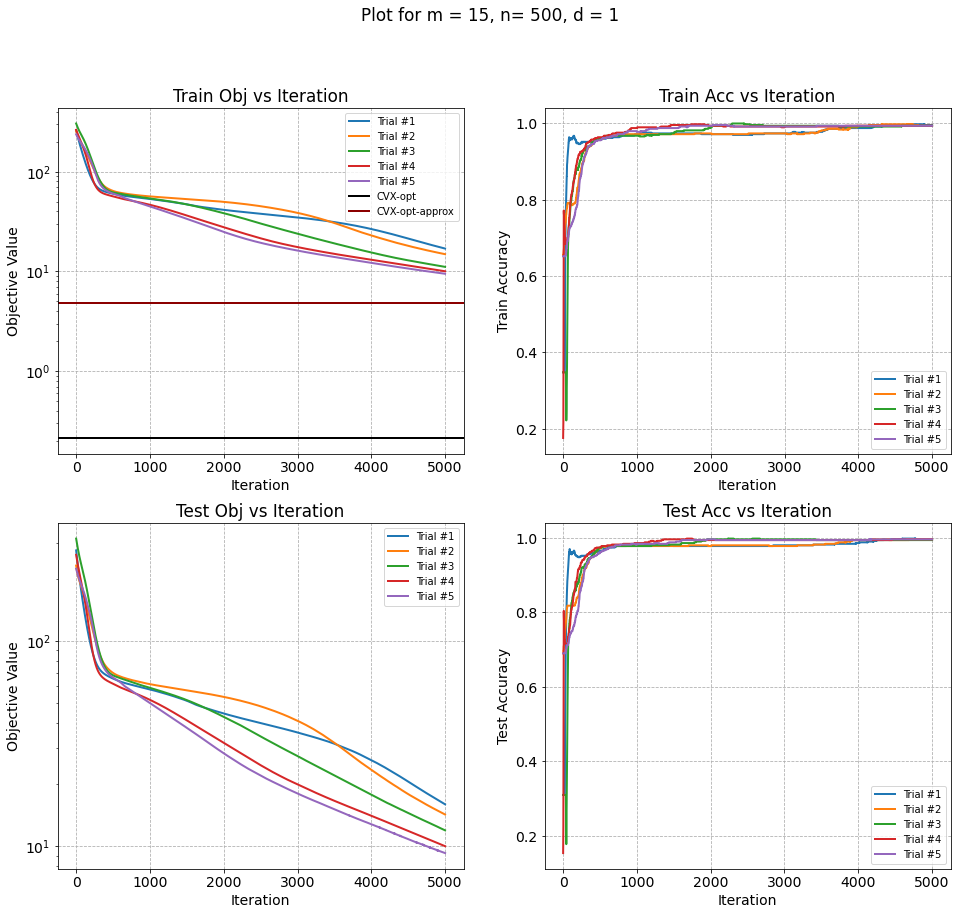

In [38]:
input_dim = 1
num_hidden_units = 15
num_classes = 2
num_samples = 1000
num_epochs = 5000
batch_size = 500
split_data = True
num_trials = 5

solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                    num_epochs, batch_size, split_data, num_trials, is_q8=True)

Dmat Unique Shape: (500, 899)
Convex program objective value (eq (8)):  0.06565978260525755
Dmat Unique Shape: (500, 72)
Convex program objective value (eq (8)):  0.06611374904851539


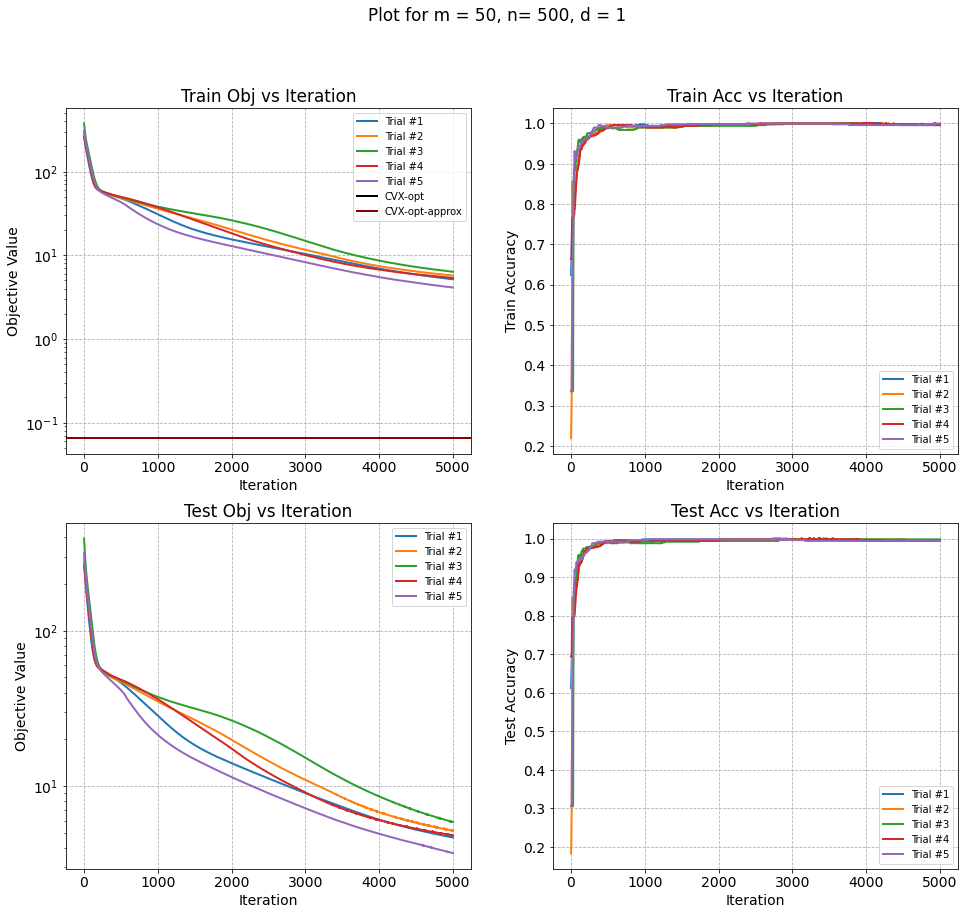

In [39]:
input_dim = 1
num_hidden_units = 50
num_classes = 2
num_samples = 1000
num_epochs = 5000
batch_size = 500
split_data = True
num_trials = 5

solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                    num_epochs, batch_size, split_data, num_trials, is_q8=True)

Dmat Unique Shape: (500, 892)
Convex program objective value (eq (8)):  0.10085867445692462
Dmat Unique Shape: (500, 67)
Convex program objective value (eq (8)):  3.26831115966998


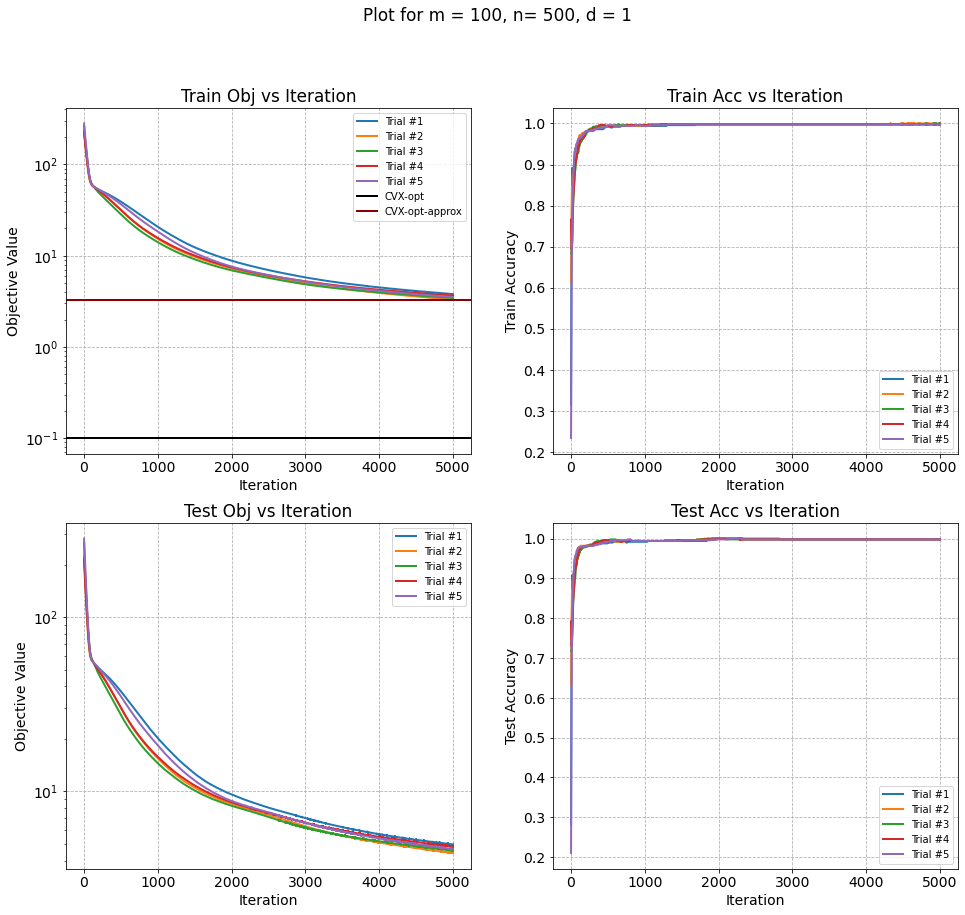

In [40]:
input_dim = 1
num_hidden_units = 100
num_classes = 2
num_samples = 1000
num_epochs = 5000
batch_size = 500
split_data = True
num_trials = 5

solve_nonconvex_SGD(input_dim, num_hidden_units, num_classes, num_samples, 
                    num_epochs, batch_size, split_data, num_trials, is_q8=True)

## Experiment - Binary Classification Task on CIFAR - 10 

### Q9. Perform an experiment for the binary classification task on CIFAR-10 dataset. Choose any two classes you prefer. Choose the value of m appropriately. Train the network using SGD on the non-convex problem for different initializations. Solve the approximate convex program with CVX/CVPY. Plot objective value vs iterations. Evaluate the performance of trained networks on the test set, and plot test accuracy vs iterations. Comment on your observations.

- We choose the class labels - 0 and 1 - and extract 5000x2 training and 1000x2 test samples corresponding to these 2 classes. Each data sample is linearized into a 3072-dim vector. We use m=100 hidden neurons.


- Running the convex solver CVXPY on 10000 training samples requires high computation power and it lead to my PC running out of memory. I tried running it on UCSD DSMLP cluster but there also the CVXPY solver did not converge and seems to be taking infinite amount of time. Therefore, I sampled small amounts of data for each of the 2 classes and performed SGD training and convex optimization with this small batch of CIFAR-10 data.


- For our CIFAR-10 experiment, we use all the 3072 features. For each class - 0,1 - we used 100 training samples and 50 test samples per class. Also, m = 100 and n = 200 which might be the reason for the big gap between SGD loss and convex loss.


- From the plot, we can see that the training objective curve is well above the convex optimal value. The test loss is also decreasing and saturates after some iterations. In addition, the training and test accuracy plots further assure that there is no overfitting of data.  

In [41]:
directory = os.path.dirname(os.path.realpath("./"))
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])

train_dataset = datasets.CIFAR10(directory, train=True, download=True, 
                                 transform=transforms.Compose([transforms.ToTensor(), normalize,]))

test_dataset = datasets.CIFAR10(directory, train=False, download=True, 
                                transform=transforms.Compose([transforms.ToTensor(), normalize,]))

Files already downloaded and verified
Files already downloaded and verified


In [42]:
# data extraction
print('Extracting CIFAR-10 dataset')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50000, shuffle=True, 
                                           pin_memory=True, sampler=None)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False, 
                                           pin_memory=True, sampler=None)

for train_x, train_y in train_loader:
    pass

for test_x, test_y in test_loader:
    pass

train_x = train_x.view(train_x.shape[0], -1)
test_x = test_x.view(test_x.shape[0], -1)

index_01_class = torch.where(train_y <= 1)[0]
X_train = train_x[index_01_class]
Y_train = train_y[index_01_class]

index_01_class = torch.where(test_y <= 1)[0]
X_test = test_x[index_01_class]
Y_test = test_y[index_01_class]

print("Train data size: (", X_train.shape, Y_train.shape, ") \nTest data size: (", X_test.shape, Y_test.shape, ")")

# print(np.unique(Y_train), np.unique(Y_test))
Y_train = (Y_train - 0.5) * 2
Y_test = (Y_test - 0.5) * 2
# print(np.unique(Y_train), np.unique(Y_test))

Extracting CIFAR-10 dataset
Train data size: ( torch.Size([10000, 3072]) torch.Size([10000]) ) 
Test data size: ( torch.Size([2000, 3072]) torch.Size([2000]) )


In [18]:
index_1_class = torch.where(Y_train == 1)[0]
index_0_class = torch.where(Y_train == -1)[0]

index_1_class = index_1_class[0:100]
index_0_class = index_0_class[0:100]
index_01_class = torch.cat((index_1_class, index_0_class), dim=0)
print(index_1_class.shape, index_0_class.shape, index_01_class.shape)

X_train_short = X_train[index_01_class]
Y_train_short = Y_train[index_01_class]

index_1_class = torch.where(Y_test == 1)[0]
index_0_class = torch.where(Y_test == -1)[0]

index_1_class = index_1_class[0:50]
index_0_class = index_0_class[0:50]
index_01_class = torch.cat((index_1_class, index_0_class), dim=0)
print(index_1_class.shape, index_0_class.shape, index_01_class.shape)

X_test_short = X_test[index_01_class]
Y_test_short = Y_test[index_01_class]

print("Train data size: (", X_train_short.shape, Y_train_short.shape, ") \nTest data size: (", X_test_short.shape, Y_test_short.shape, ")")

torch.Size([100]) torch.Size([100]) torch.Size([200])
torch.Size([50]) torch.Size([50]) torch.Size([100])
Train data size: ( torch.Size([200, 3072]) torch.Size([200]) ) 
Test data size: ( torch.Size([100, 3072]) torch.Size([100]) )


SGD Training Complete !!! --> Starting CVXPY Optim
Dmat Unique Shape: (200, 10)
Convex program objective value (eq (8)):  8.13348744996559e-05


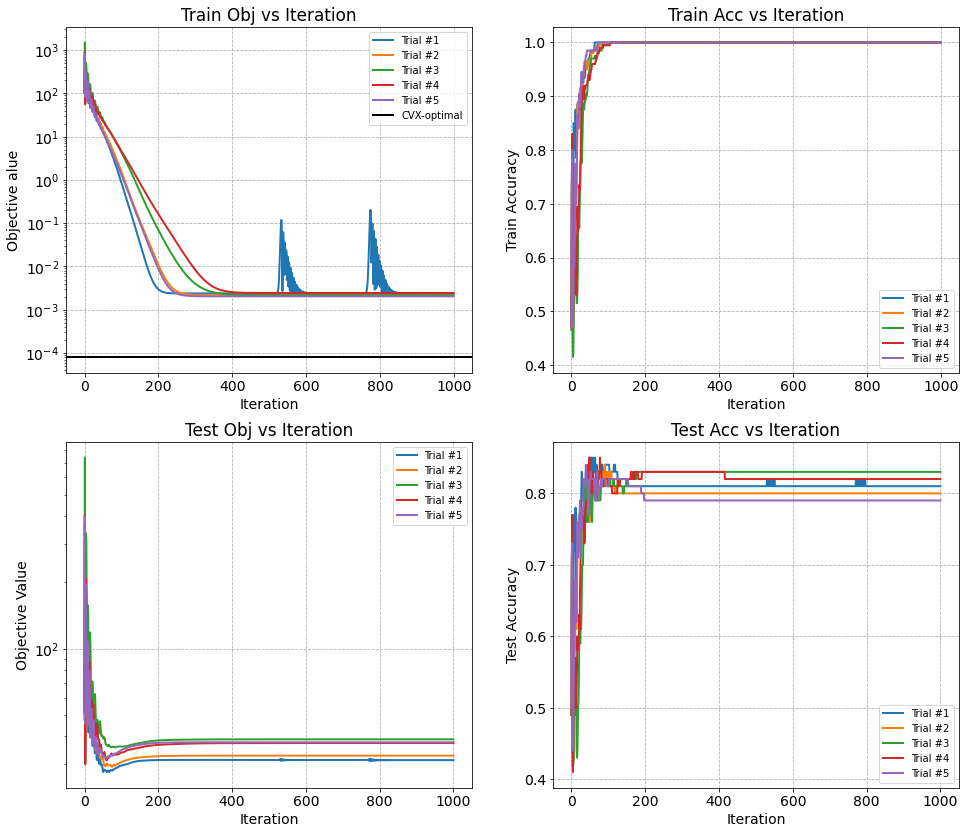

In [46]:
input_dim = X_train_short.shape[1]
num_hidden_units = 100
num_classes = 2
num_train_samples = X_train_short.shape[0]
num_epochs = 1000
batch_size = num_train_samples // 1
num_trials = 5
step_size = 1e-3
beta = 1e-4

fig = plt.figure(figsize=(16,14))
ax1 = fig.add_subplot(2,2,1)
ax1.set_yscale('log')
ax1.title.set_text("Train Obj vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective alue")
plt.grid(linestyle='--')

ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text("Train Acc vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Train Accuracy")
plt.grid(linestyle='--')

ax3 = fig.add_subplot(2,2,3)
ax3.set_yscale('log')
ax3.title.set_text("Test Obj vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.grid(linestyle='--')

ax4 = fig.add_subplot(2,2,4)
ax4.title.set_text("Test Acc vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy")
plt.grid(linestyle='--')

lw = 2
# color_lst = ['red', 'blue', 'lightcoral', 'lime', 'darkred', 'lightblue', 'green']

for trial in range(num_trials):
    train_loss_lst, train_acc_lst, test_loss_lst, test_acc_lst = sgd_solver(X_train_short, Y_train_short, 
                                                                            X_test_short, Y_test_short, 
                                                                            input_dim, num_hidden_units, 
                                                                            num_classes, num_epochs, batch_size,
                                                                            step_size, beta)

    line, = ax1.plot(train_loss_lst, linewidth=lw, label='Trial #'+str(trial+1))
    line, = ax2.plot(train_acc_lst, linewidth=lw, label='Trial #'+str(trial+1))
    line, = ax3.plot(test_loss_lst, linewidth=lw, label='Trial #'+str(trial+1))
    line, = ax4.plot(test_acc_lst, linewidth=lw, label='Trial #'+str(trial+1))

print("SGD Training Complete !!! --> Starting CVXPY Optim")

X_train_new = np.append(X_train_short, np.ones((num_train_samples, 1)), axis=1)
cvx_opt_val = optimize_using_cvxpy(X_train_new, Y_train_short, num_train_samples, input_dim+1, 
                                   Dmat_max_itr=10, beta=beta)

ax1.axhline(cvx_opt_val, color='black', linewidth=2, linestyle='-', label='CVX-optimal')

ax1.legend(prop={'size': 10})
ax2.legend(prop={'size': 10})
ax3.legend(prop={'size': 10})
ax4.legend(prop={'size': 10})

plt.show()